In [1]:
%pylab inline
import pickle
import pandas as pd
import xgboost as xgb

Populating the interactive namespace from numpy and matplotlib


## Significance Scan

In [2]:
training_columns=[ 'V0CosPA','ProngsDCA', 'DistOverP', 'ArmenterosAlpha','NpidClustersHe3','V0pt','TPCnSigmaHe3']

In [3]:
df_18r=pd.read_pickle('df_Sig_data.pkl')

In [4]:
model_list=[]
model_list.append(pickle.load(open("model_cent_1.pkl", "rb")))
model_list.append(pickle.load(open("model_cent_2.pkl", "rb")))
model_list.append(pickle.load(open("model_cent_3.pkl", "rb")))


In [5]:
def SignificanceScan(df,cent):
    sig_array=[]    
    sign_array=[]
    max_score=np.max(df['Score'])
    min_score=0
    score_list=np.linspace(min_score,max_score,50)
    for i in score_list:
        df_cut=df.query('Score>@i')['InvMass']
        counts,bins=np.histogram(df_cut,bins=50,range=[2.96,3.04]);
        bin_centers = 0.5*(bins[1:]+bins[:-1])
        sidemap=(bin_centers<2.9923-3*0.0029) + (bin_centers>2.9923+3*0.0029)
        massmap=logical_not(sidemap)
        bins_side = bin_centers[sidemap]
        counts_side= counts[sidemap]
        h=polyfit(bins_side,counts_side,2)
        y=polyval(h,bins_side)
        counts_mass= sum(counts[massmap])
        bkg=sum(polyval(h,bin_centers[massmap]))
        sig=counts_mass-bkg
        significance=sig/sqrt(sig+bkg+1e-10)
        sig_array.append(sig)
        sign_array.append(significance)
        
    max_sign=np.max(sign_array)  
    max_index=int(np.unique(np.where(sign_array==max_sign))) 
    max_score=score_list[max_index]
    ryield=sig_array[max_index]
    df_cut=df.query('Score>@max_score')
    counts,_=np.histogram(df_cut,bins=50,range=[2.96,3.04]);
    h=polyfit(bins_side,counts[sidemap],2)
    y=polyval(h,bins_side)    
    fig, axs = plt.subplots(1,2, figsize=(9, 3))   
    axs[0].plot(score_list,sign_array,'b')
    axs[0].set_xlabel('Score')
    axs[0].set_ylabel('Significance')
    axs[1].plot(bin_centers[sidemap],counts[sidemap],'b.')
    axs[1].plot(bin_centers[massmap],counts[massmap],'g.')    
    axs[1].plot(bin_centers[sidemap],y,'r-')
    axs[1].set_xlabel('InvMass')
    axs[1].set_ylabel('Counts')
    plt.suptitle("Centrality = %s, Best Score = %0.2f, Significance = %0.2f, Raw yield = %0.2f" %(cent,max_score,np.max(sign_array),ryield))
    sig_array=np.asarray(sig_array)
    return max_score

In [6]:
df_18r=df_18r.astype('float')
df_list=[]
df_list.append(df_18r.query('0<Centrality<10'))
df_list.append(df_18r.query('10<Centrality<30'))
df_list.append(df_18r.query('30<Centrality<50'))

/home/fmazzasc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<Figure size 432x288 with 0 Axes>

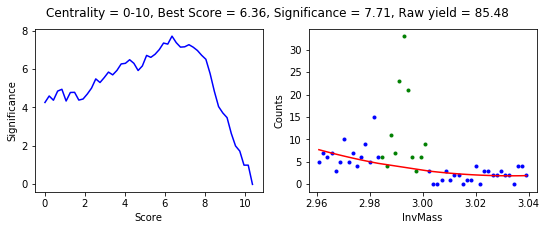

<Figure size 432x288 with 0 Axes>

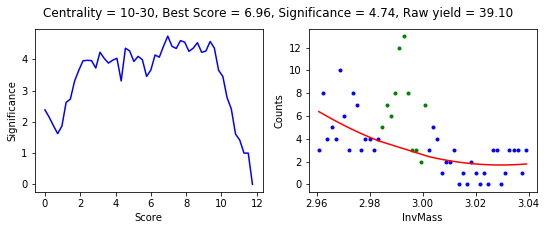

<Figure size 432x288 with 0 Axes>

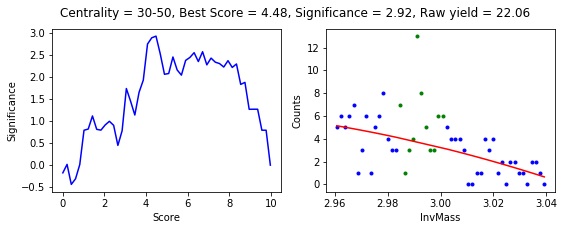

In [7]:
centrality_list=['0-10','10-30','30-50']
best_score_list=[]
for i in range(0,3):
    plt.figure();
    dtest = xgb.DMatrix(data=df_list[i][training_columns],silent=True)
    df_list[i]['Score']=model_list[i].predict(dtest,output_margin=True)
    best_score_list.append(SignificanceScan(df_list[i],centrality_list[i]))
    del dtest

# Best score efficiency

In [8]:
fit_efficiency_array=np.load("fit_efficiency_array.npy")

In [9]:
for i in range(0,3):
    y=polyval(fit_efficiency_array[i,:],best_score_list[i])
    print("Best score efficiency for %s centrality: %0.2f"%(centrality_list[i],y))

Best score efficiency for 0-10 centrality: 0.75
Best score efficiency for 10-30 centrality: 0.79
Best score efficiency for 30-50 centrality: 0.93
